## Import required libraries

In [ ]:
import os
import random
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

In [15]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [16]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load dataset

In [2]:
%%time
ROOT = './data'
train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)

VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])

mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transform
valid_data.dataset.transform = test_transform
test_data.transform = test_transform

BATCH_SIZE = 256
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21455330.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 996616.07it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9664721.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1442784.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

CPU times: user 1.5 s, sys: 771 ms, total: 2.27 s
Wall time: 3.63 s


In [18]:
train_data.dataset.data.shape, valid_data.dataset.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

In [19]:
train_data.dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [20]:
def plot_images(images):
    num_images = len(images)
    rows = cols = int(np.sqrt(num_images))

    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten()):
        if i < num_images:
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

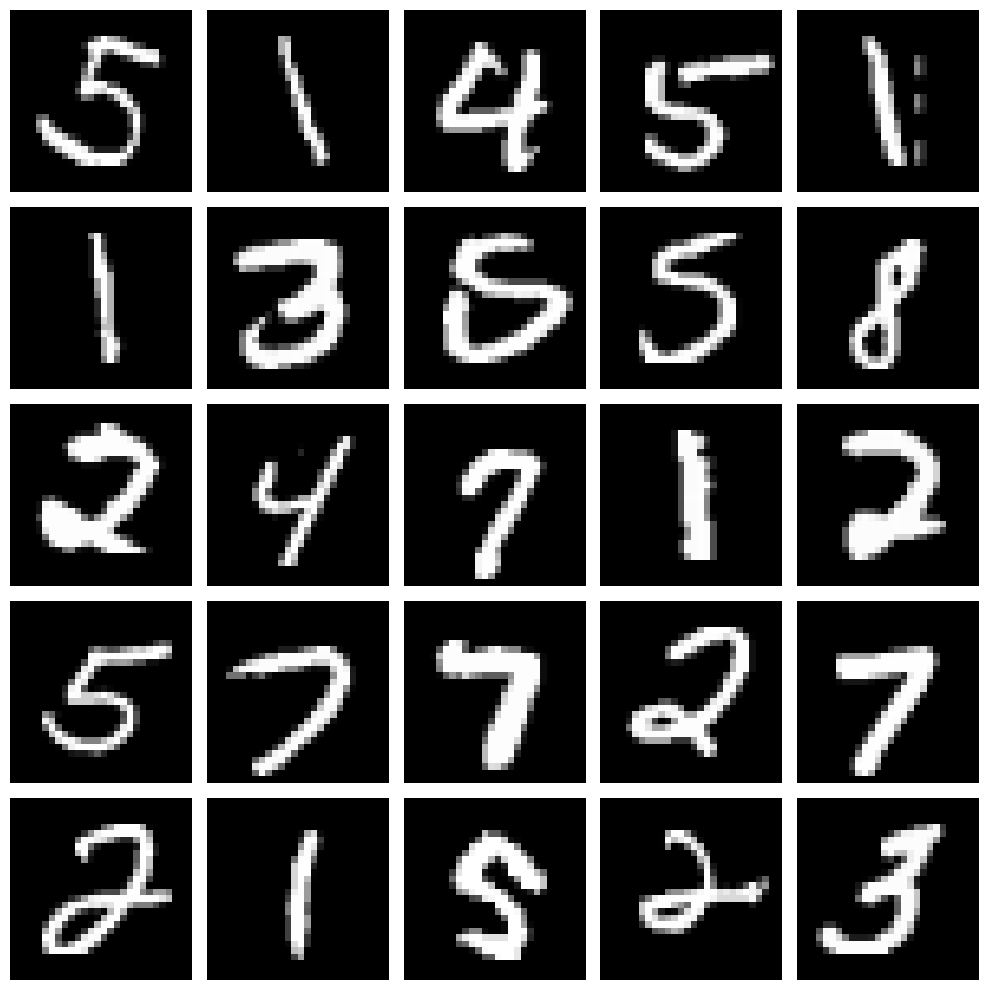

In [21]:
num_images = 25
images, labels = next(iter(train_loader))
images = images[:num_images]
plot_images(images)

## Define LeNet

In [22]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, X):
        X = F.relu(self.avgpool1(self.conv1(X)))
        X = F.relu(self.avgpool2(self.conv2(X)))
        X = self.flatten(X)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X

## Training and Evaluation

In [23]:
def train(model, train_loader, optimizer, criterion, device, epoch=0, log_interval=50):
    model.train()
    train_acc, count = 0.0, 0
    losses = []
    start_time = time.time()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
        count += len(labels)
        if batch_idx % log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print(f'| epoch {epoch+1:3d} | {batch_idx:5d}/{len(train_loader):d} batches '
                f'| accuracy {train_acc/count:8.3f}'
            )
            train_acc, count = 0.0, 0
            start_time = time.time()

    epoch_acc = train_acc / count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

def evaluate(model, val_loader, criterion, device):
    model.eval()
    eval_acc, count = 0.0, 0
    losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            eval_acc += (outputs.argmax(dim=1) == labels).sum().item()
            count += len(labels)

    epoch_acc = eval_acc / count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_data.dataset.classes)

lenet_model = LeNetClassifier(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(epochs):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(lenet_model, train_loader, optimizer, criterion, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, val_loader, criterion, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(lenet_model.state_dict(), os.path.join(save_model, 'lenet_model_mnist.pt'))

    print('-' * 59)
    print(f'| End of epoch {epoch+1:3d} | Time: {time.time() - epoch_start_time:5.2f}s '
        f'| Train Accuracy: {train_acc:8.3f} | Train Loss: {train_loss:8.3f} | '
        f'Val Accuracy: {eval_acc:8.3f} | Val Loss: {eval_loss:8.3f} '
    )
    print('-' * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(os.path.join(save_model, 'lenet_model_mnist.pt')))
    lenet_model.eval()

| epoch   1 |    50/211 batches | accuracy    0.656
| epoch   1 |   100/211 batches | accuracy    0.883
| epoch   1 |   150/211 batches | accuracy    0.919
| epoch   1 |   200/211 batches | accuracy    0.941
-----------------------------------------------------------
| End of epoch   1 | Time: 15.14s | Train Accuracy:    0.948 | Train Loss:    0.490 | Val Accuracy:    0.946 | Val Loss:    0.183 
-----------------------------------------------------------


<ipython-input-24-e3c30a91a74a>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(os.path.join(save_model, 'lenet_model_mnist.pt')))


| epoch   2 |    50/211 batches | accuracy    0.955
| epoch   2 |   100/211 batches | accuracy    0.962
| epoch   2 |   150/211 batches | accuracy    0.963
| epoch   2 |   200/211 batches | accuracy    0.966
-----------------------------------------------------------
| End of epoch   2 | Time: 15.49s | Train Accuracy:    0.963 | Train Loss:    0.126 | Val Accuracy:    0.964 | Val Loss:    0.119 
-----------------------------------------------------------
| epoch   3 |    50/211 batches | accuracy    0.968
| epoch   3 |   100/211 batches | accuracy    0.972
| epoch   3 |   150/211 batches | accuracy    0.974
| epoch   3 |   200/211 batches | accuracy    0.975
-----------------------------------------------------------
| End of epoch   3 | Time: 14.78s | Train Accuracy:    0.977 | Train Loss:    0.091 | Val Accuracy:    0.975 | Val Loss:    0.093 
-----------------------------------------------------------
| epoch   4 |    50/211 batches | accuracy    0.977
| epoch   4 |   100/211 batche

In [25]:
test_acc, test_loss = evaluate(lenet_model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:8.3f} | Test Loss: {test_loss:8.3f}')

Test Accuracy:    0.985 | Test Loss:    0.049


In [34]:
def plot_results(epochs, train_accs, train_losses, eval_accs, eval_losses):
    x_range = range(epochs)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(x_range, train_losses, 'b', label='Training Loss')
    plt.plot(x_range, eval_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_range, train_accs, 'b', label='Training Accuracy')
    plt.plot(x_range, eval_accs, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

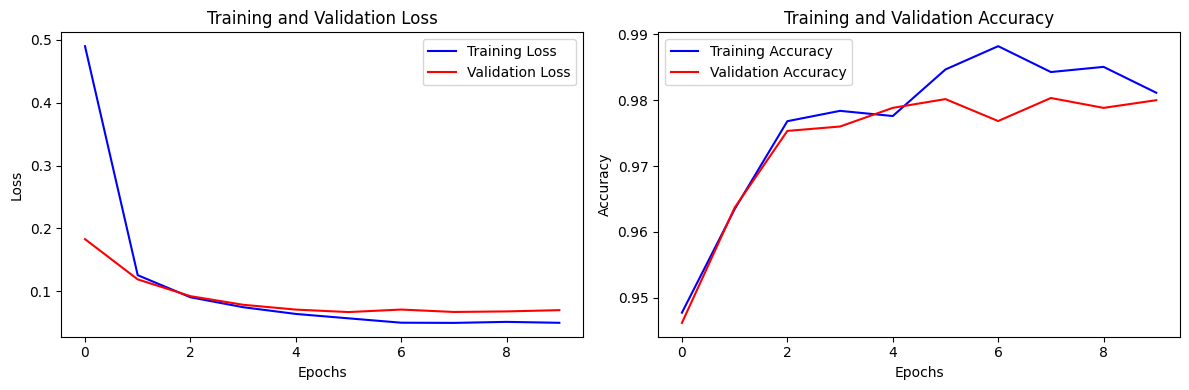

In [35]:
plot_results(epochs, train_accs, train_losses, eval_accs, eval_losses)